In this notebook, we'll look at featurizing fatigue to see if we can get lift on our models through this.
The Sipko paper indicates that fatigue can be featurized by:

* Number of matches played in last 3 days
* Indicator for whether this is the first match back after retiring from one 

In [1]:
SURFACE = 'Clay'

In [2]:
from fetch.match_results import read_joined 

df, player_mapping, inverse_player_mapping = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# Before 2003, no distinction in date between matches
df = df[df['date'] >= '2003-01-01'].copy()

In [4]:
df.sort(['date', 'round'], inplace=True)

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


#### Retirement
Let's look at whether people who retired in their last match actually do worse

In [5]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt


def mvg_average_plot(df, sort_col, outcome_col, window=500, qmin=0.01, qmax=0.99):
    sorted_df = df.sort_values(by=sort_col)
    out = pd.rolling_mean(sorted_df[outcome_col], window=window)
    plt.plot(sorted_df[sort_col], out)
    plt.xlabel(sort_col)
    plt.xlim((
        df[sort_col].quantile(qmin),
        df[sort_col].quantile(qmax)
    ))

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,center=False).mean()
  


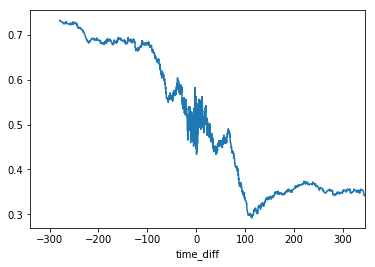

In [6]:
mvg_average_plot(df, 'time_diff', 'y')

The greater the time since a player's last match, the worse they perform!  This may be because worse players don't last til the end of a tournament

In [7]:
import numpy as np

df['time_diff'].describe(percentiles=np.linspace(0, 1, 21))

count    38421.000000
mean         0.420369
std        123.411848
min      -3641.000000
0%       -3641.000000
5%         -49.000000
10%        -17.000000
15.0%       -8.000000
20%         -4.000000
25%         -2.000000
30.0%       -1.000000
35%          0.000000
40%          0.000000
45%          0.000000
50%          0.000000
55.0%        0.000000
60.0%        0.000000
65%          0.000000
70%          1.000000
75%          2.000000
80%          4.000000
85.0%        8.000000
90%         18.000000
95%         53.000000
100%      5596.000000
max       5596.000000
Name: time_diff, dtype: float64

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000,center=False).mean()
  


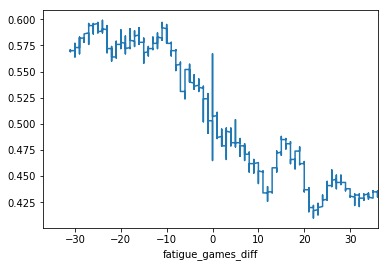

In [8]:
mvg_average_plot(df, 'fatigue_games_diff', 'y', window=1000)

In [9]:
df.groupby('fatigue_diff').apply(
    lambda x: (x.shape[0], x['y'].mean())
)

fatigue_diff
-3.0        (3, 0.333333333333)
-2.0      (123, 0.471544715447)
-1.0     (4166, 0.571531445031)
 0.0    (29800, 0.503489932886)
 1.0     (4183, 0.459956968683)
 2.0      (144, 0.534722222222)
 3.0                   (1, 0.0)
 4.0                   (1, 1.0)
dtype: object

When someone has played an extra match in the past 3 days, they seem to do much worse!  When someone has played more games in the past 3 days they also do worse!

It seems like there is something real about these fatigue features...how normal looking are they? 

In [10]:
df.groupby('retire_diff').apply(
    lambda x: (x.shape[0], x['y'].mean())
)

retire_diff
-1.0      (643, 0.514774494557)
 0.0    (37192, 0.506211013121)
 1.0      (586, 0.491467576792)
dtype: object

Players that retired in their last match do in fact perform worse

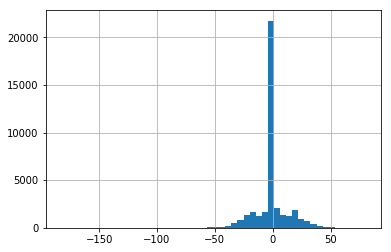

In [11]:
df['fatigue_games_diff'].hist(bins=50)

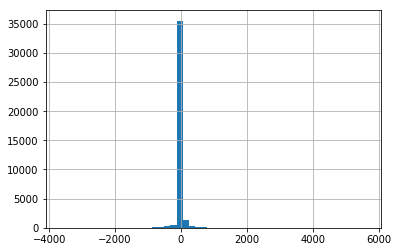

In [12]:
df['time_diff'].hist(bins=50)

Might need to split these into 0 and non-0...

#### Logit Model 

##### Add Fatigue Interactions with Length of Match to Dataset

In [13]:
# TODO: Add interactions with Age
ORIG_NEW_FEATS = [
    'fatigue_games_diff',
    'retire_diff',
    'time_diff',
    'comeback_diff'
]

NEW_FEATS = [x for x in ORIG_NEW_FEATS]
for feat in ORIG_NEW_FEATS:
    best_of_interaction = '%s*best_of_5' % feat
    df[best_of_interaction] = df[feat] * df['best_of_5']
NEW_FEATS.extend(['%s*best_of_5' % feat for feat in ORIG_NEW_FEATS])

##### Non-Updated Model with No Additional Features

In [14]:
MIN_TRAIN_DATE = '2004-01-01'
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

train_df = df[
    (df['date'] >= MIN_TRAIN_DATE) &
    (df['date'] < MIN_TEST_DATE)
].copy()
test_df = df[
    (df['date'] >= MIN_TEST_DATE) &
    (df['date'] < MAX_TEST_DATE) &
    (df['__surface__'] == SURFACE) &
    (~df['comment'].isin(['Retired', 'Walkover']))
].copy()

In [15]:
from models.logit.base import get_X_y

orig_train_X, orig_train_y = get_X_y(train_df, player_mapping)
orig_test_X, orig_test_y = get_X_y(test_df, player_mapping)

In [16]:
from models.logit.base import sipko_weights

DISCOUNT = 0.8
FLAT_TIME = 1.0
PRIOR = 0.
LMBDA = 1.

time_weights = sipko_weights(
    train_df['date'].max(),
    train_df,
    DISCOUNT,
    flat_time=FLAT_TIME
)
surface_weights = train_df['__surface__'].map(
    lambda x: {
        'Hard': 0.4,
        'Clay': 1.0,
        'Grass': 0.0, 
        'Indoor': 0.6
    }[x]
)
sample_weights = time_weights * surface_weights

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logit = LogisticRegression(C=10)
logit.fit(orig_train_X, orig_train_y, sample_weight=sample_weights)
preds = logit.predict_proba(orig_test_X)[:, 1]
orig_auc = roc_auc_score(orig_test_y, preds)
orig_auc

0.73271027094639574

Original AUC of 0.733

##### Now let's add some additional features

In [18]:
from scipy import sparse

new_train_X = sparse.hstack([
    orig_train_X,
    sparse.csc_matrix(train_df[NEW_FEATS].values)
])
new_test_X = sparse.hstack([
    orig_test_X,
    sparse.csc_matrix(test_df[NEW_FEATS].values)
])

In [19]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=20.)
logit.fit(new_train_X, orig_train_y, sample_weight=sample_weights)

LogisticRegression(C=20.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
zip(NEW_FEATS, logit.coef_[0][-len(NEW_FEATS):])

[('fatigue_games_diff', -0.0028807797371970438),
 ('retire_diff', -0.26002749416657872),
 ('time_diff', 0.00024196368113826394),
 ('comeback_diff', -0.17251338433327676),
 ('fatigue_games_diff*best_of_5', -0.0060279630982103607),
 ('retire_diff*best_of_5', -0.018415053515643681),
 ('time_diff*best_of_5', -1.4903510253663001e-05),
 ('comeback_diff*best_of_5', -0.28842842853132011)]

In [21]:
train_preds = logit.predict_proba(new_train_X)[:, 1]
train_auc = roc_auc_score(orig_train_y, train_preds)
train_auc

0.75379363407775091

In [22]:
_preds = logit.predict_proba(new_test_X)[:, 1]
roc_auc_score(orig_test_y, _preds)

0.73824217725502861

Get half a point of AUC from adding these fatigue features...not bad!

#### Try updating as we go 

Now we will try updating this model as we go...

In [23]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

def try_update_period(update_period=10, include_fatigue=False):
    preds = []
    cur_date = pd.to_datetime(MIN_TEST_DATE)
    while(cur_date < pd.to_datetime(MAX_TEST_DATE)):
        print cur_date
        cur_train_df = df[
            (df['date'] >= MIN_TRAIN_DATE) &
            (df['date'] < cur_date)
        ].copy()
        cur_test_df = df[
            (df['date'] >= cur_date) &
            (df['date'] < cur_date + pd.Timedelta(days=update_period)) &
            (df['date'] < MAX_TEST_DATE) &
            (df['__surface__'] == SURFACE) &
            (~df['comment'].isin(['Retired', 'Walkover']))  # Remove retire from test set
        ].copy()
        if cur_test_df.shape[0] > 0:
            train_X, train_y = get_X_y(cur_train_df, player_mapping)
            test_X, test_y = get_X_y(cur_test_df, player_mapping)

            if include_fatigue:
                train_X = sparse.hstack([
                    train_X,
                    sparse.csc_matrix(cur_train_df[NEW_FEATS].values)
                ])
                test_X = sparse.hstack([
                    test_X,
                    sparse.csc_matrix(cur_test_df[NEW_FEATS].values)
                ])

            time_weights = sipko_weights(
                cur_train_df['date'].max(),
                cur_train_df,
                DISCOUNT,
                flat_time=FLAT_TIME
            )
            surface_weights = cur_train_df['__surface__'].map(
                lambda x: {
                    'Hard': 0.4,
                    'Clay': 1.0,
                    'Grass': 0.0,
                    'Indoor': 0.6 
                }[x]
            )
            sample_weights = time_weights * surface_weights

            logit = LogisticRegression(C=20.)
            logit.fit(train_X, train_y, sample_weight=sample_weights)
            preds.extend(logit.predict_proba(test_X)[:, 1].tolist())
        cur_date = cur_date + pd.Timedelta(days=update_period)
    auc = roc_auc_score(orig_test_y, preds)
    return auc, preds

In [24]:
NEW_FEATS

['fatigue_games_diff',
 'retire_diff',
 'time_diff',
 'comeback_diff',
 'fatigue_games_diff*best_of_5',
 'retire_diff*best_of_5',
 'time_diff*best_of_5',
 'comeback_diff*best_of_5']

In [ ]:
auc, preds = try_update_period(update_period=1)

In [ ]:
auc

Get up to 0.748 AUC by refitting all the time -- this is not as good as true ELO, which gets us to 0.761.  Why not!?  These really should be quite similar...is it the time weighting parametrization?  What happens with fatigue features?

In [25]:
auc, preds = try_update_period(update_period=1, include_fatigue=True)

2015-01-01 00:00:00
2015-01-02 00:00:00
2015-01-03 00:00:00
2015-01-04 00:00:00
2015-01-05 00:00:00
2015-01-06 00:00:00
2015-01-07 00:00:00
2015-01-08 00:00:00
2015-01-09 00:00:00
2015-01-10 00:00:00
2015-01-11 00:00:00
2015-01-12 00:00:00
2015-01-13 00:00:00
2015-01-14 00:00:00
2015-01-15 00:00:00
2015-01-16 00:00:00
2015-01-17 00:00:00
2015-01-18 00:00:00
2015-01-19 00:00:00
2015-01-20 00:00:00
2015-01-21 00:00:00
2015-01-22 00:00:00
2015-01-23 00:00:00
2015-01-24 00:00:00
2015-01-25 00:00:00
2015-01-26 00:00:00
2015-01-27 00:00:00
2015-01-28 00:00:00
2015-01-29 00:00:00
2015-01-30 00:00:00
2015-01-31 00:00:00
2015-02-01 00:00:00
2015-02-02 00:00:00
2015-02-03 00:00:00
2015-02-04 00:00:00
2015-02-05 00:00:00
2015-02-06 00:00:00
2015-02-07 00:00:00
2015-02-08 00:00:00
2015-02-09 00:00:00
2015-02-10 00:00:00
2015-02-11 00:00:00
2015-02-12 00:00:00
2015-02-13 00:00:00
2015-02-14 00:00:00
2015-02-15 00:00:00
2015-02-16 00:00:00
2015-02-17 00:00:00
2015-02-18 00:00:00
2015-02-19 00:00:00


2016-02-16 00:00:00
2016-02-17 00:00:00
2016-02-18 00:00:00
2016-02-19 00:00:00
2016-02-20 00:00:00
2016-02-21 00:00:00
2016-02-22 00:00:00
2016-02-23 00:00:00
2016-02-24 00:00:00
2016-02-25 00:00:00
2016-02-26 00:00:00
2016-02-27 00:00:00
2016-02-28 00:00:00
2016-02-29 00:00:00
2016-03-01 00:00:00
2016-03-02 00:00:00
2016-03-03 00:00:00
2016-03-04 00:00:00
2016-03-05 00:00:00
2016-03-06 00:00:00
2016-03-07 00:00:00
2016-03-08 00:00:00
2016-03-09 00:00:00
2016-03-10 00:00:00
2016-03-11 00:00:00
2016-03-12 00:00:00
2016-03-13 00:00:00
2016-03-14 00:00:00
2016-03-15 00:00:00
2016-03-16 00:00:00
2016-03-17 00:00:00
2016-03-18 00:00:00
2016-03-19 00:00:00
2016-03-20 00:00:00
2016-03-21 00:00:00
2016-03-22 00:00:00
2016-03-23 00:00:00
2016-03-24 00:00:00
2016-03-25 00:00:00
2016-03-26 00:00:00
2016-03-27 00:00:00
2016-03-28 00:00:00
2016-03-29 00:00:00
2016-03-30 00:00:00
2016-03-31 00:00:00
2016-04-01 00:00:00
2016-04-02 00:00:00
2016-04-03 00:00:00
2016-04-04 00:00:00
2016-04-05 00:00:00


In [26]:
auc

0.75246434119474648

0.7525 with fatigue and updates, so a quarter of a point over fatigue and no updates...